In [145]:
from Process import GPModeling as gpm
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from scipy.interpolate import interp1d


# Step 1: Load Data Providing Path


In [146]:
path1 = r"C:\Users\Edwin\Desktop\OT2-DOE\PlanPrepareProcess\Temp or Working\DLS\07_22_21_Dls_Viscosity_Corrected_Complete"
# path1 = r"C:\Users\Edwin\Desktop\OT2-DOE\PlanPrepareProcess\Temp or Working\06_08_21_5CB_Blanked_Abs_POTFIX"

In [147]:
full_data = gpm.load_datadf(path1)
# SDS = full_data['SDS concentration wtf'].unique()[1]
# full_data =  full_data[full_data['SDS concentration wtf']==SDS]
# full_data = full_data[full_data['Aliquot']==2]
full_data = full_data[full_data['Run']==1]
# full_data = full_data[full_data['Attenuator']<11]

# Step 2: Apply any filters due to errors (i.e. foaming or other notable observation)


In [148]:
# full_data = full_data[full_data['Run']==2]
# full_data = full_data[full_data['Attenuator']<11]
full_data

,UID,Labware,Slot,Well,ODE concentration wtf,SDS concentration wtf,ethanol concentration wtf,water concentration wtf,ODE amount mass g,ODE amount volume uL,...,Intensities[61] (Percent),Intensities[62] (Percent),Intensities[63] (Percent),Intensities[64] (Percent),Intensities[65] (Percent),Intensities[66] (Percent),Intensities[67] (Percent),Intensities[68] (Percent),Intensities[69] (Percent),Intensities[70] (Percent)
0,S2_A1_07-27-2021,Abgene 96 Well Plate 2200 ÂµL,2,A1,0.000000,0.0001,0.2,0.799900,0.000000,0.000000,...,0.1,0.2,0.4,0.5,0.7,0.8,0.0,0.0,0.0,0.0
2,S2_A2_07-27-2021,Abgene 96 Well Plate 2200 ÂµL,2,A2,0.000000,0.0001,0.4,0.599900,0.000000,0.000000,...,0.3,0.5,0.8,0.9,1.1,1.1,0.0,0.0,0.0,0.0
4,S2_A3_07-27-2021,Abgene 96 Well Plate 2200 ÂµL,2,A3,0.000000,0.0001,0.6,0.399900,0.000000,0.000000,...,9.5,8.5,6.9,4.9,2.9,1.3,0.0,0.0,0.0,0.0
6,S2_A4_07-27-2021,Abgene 96 Well Plate 2200 ÂµL,2,A4,0.000000,0.0001,0.8,0.199900,0.000000,0.000000,...,10.8,9.0,6.6,4.1,2.0,0.6,0.0,0.0,0.0,0.0
8,S2_A5_07-27-2021,Abgene 96 Well Plate 2200 ÂµL,2,A5,0.000111,0.0001,0.3,0.699789,0.000133,0.168990,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,S2_F7_07-27-2021,Abgene 96 Well Plate 2200 ÂµL,2,F7,0.000889,0.0001,0.7,0.299011,0.001067,1.351922,...,0.0,0.0,0.0,0.0,0.0,6.1,0.0,0.0,0.0,0.0
132,S2_F8_07-27-2021,Abgene 96 Well Plate 2200 ÂµL,2,F8,0.001000,0.0001,0.2,0.798900,0.001200,1.520913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,S2_F9_07-27-2021,Abgene 96 Well Plate 2200 ÂµL,2,F9,0.001000,0.0001,0.4,0.598900,0.001200,1.520913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,S2_F10_07-27-2021,Abgene 96 Well Plate 2200 ÂµL,2,F10,0.001000,0.0001,0.6,0.398900,0.001200,1.520913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Step 3: Extract Spectras

In [149]:
# wavelength_columns = [col for col in full_data.columns if 'nm' in col]
# wavelengths = [float(wavelength.replace("nm","")) for wavelength in wavelength_columns]
# full_spectra_data = full_data[wavelength_columns]
# full_spectra_data = full_spectra_data.round(3)
# full_spectra_data

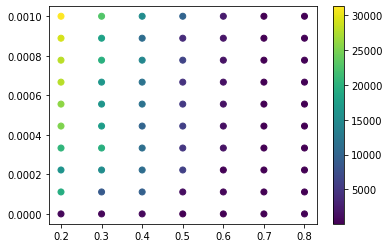

In [150]:
x_data = full_data['ethanol concentration wtf'].tolist()
y_data = full_data['ODE concentration wtf'].tolist()
z_data = full_data['Derived Count Rate (kcps)'].tolist()

plt.scatter(x_data, y_data, c = z_data)
plt.colorbar()

# for i, row in full_spectra_data.iterrows():
#     row = list(row)
#     plt.plot(wavelengths,row)
# plt.xlabel('Wavelength nm')
# plt.ylabel('AU')

In [151]:
# load and standardize data
x1_training = np.asarray(x_data)
x2_training = np.asarray(y_data)
y_training = np.asarray(z_data)

x1_training_scaled, x1_scaler = gpm.standardize_training(x1_training)
x2_training_scaled, x2_scaler = gpm.standardize_training(x2_training)
y_training_scaled, y_scaler = gpm.standardize_training(y_training)
x1x2_training_scaled = np.asarray([x1_training_scaled[:,0], x2_training_scaled[:,0]]).T

In [152]:
# set min/max
scale = 1.5
x1_sct_min = min(x1_training_scaled) + min(x1_training_scaled)*scale
x1_sct_max = max(x1_training_scaled) + max(x1_training_scaled)*scale
x2_sct_min = min(x2_training_scaled) + min(x2_training_scaled)*scale
x2_sct_max = max(x2_training_scaled) + max(x2_training_scaled)*scale

# Create the model and fit the data 
# kernal = 1.0 * RBF(length_scale=1, length_scale_bounds=(1E-6,10)) \
#     + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)) 
kernal = 1.0 * RBF(length_scale=60, length_scale_bounds=(1e-3, 1e6)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)) 

gpmodel = GaussianProcessRegressor(kernel=kernal, n_restarts_optimizer=10,alpha=0.05, normalize_y=True) # random_state=42
gpmodel.fit(x1x2_training_scaled, y_training_scaled)

# test data is inherently scaled given the inputs, if not then would need to rescale
x1_test = np.linspace(x1_sct_min,x1_sct_max,100)
x2_test = np.linspace(x2_sct_min,x2_sct_max,100)
x1x2_test = gpm.create_product_mesh(x1_test, x2_test)

# Run the test data through and convert results back from standardized to original units
x1_test_ex = x1x2_test[:,0][:,0]
x2_test_ex = x1x2_test[:,1][:,0]
x1x2_test_reform = np.asarray([x1_test_ex, x2_test_ex]).T
y_pred, MSE = gpmodel.predict(x1x2_test_reform, return_std=True) 

x1_test_org = x1_scaler.inverse_transform(x1x2_test[:,0]) 
x2_test_org = x2_scaler.inverse_transform(x1x2_test[:,1])
y_pred_org = y_scaler.inverse_transform(y_pred)

# Select data of interst and create meshes
x1 = x1_training
x2 = x2_training
y = y_training

dim_x1_test = x1_test.shape[0] # diff
dim_x2_test = x2_test.shape[0]

x1_mesh_prep = np.asarray([round(i,12) for i in x1_test_org[:,0]])
x2_mesh_prep = np.asarray([round(i,12) for i in x2_test_org[:,0]])
y_mesh_prep = np.asarray([round(i,5) for i in y_pred_org[:,0]])

X1 = x1_mesh_prep.reshape(dim_x2_test, dim_x1_test)
X2 = x2_mesh_prep.reshape(dim_x2_test, dim_x1_test)
Y = np.reshape(y_mesh_prep,(dim_x2_test, dim_x1_test))

gpmodel.score(x1x2_training_scaled, y_training_scaled)

# hmm play with this score and see what you can change in your kernal to modify it

c:\users\edwin\appdata\local\programs\python\python39\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


0.9708424491294521

In [153]:
%matplotlib inline

In [219]:
solubility_data = pd.read_excel(r"C:\Users\Edwin\Desktop\octadecene solubility.xlsx")
solubility_data.columns = solubility_data.loc[0]
solubility_data = solubility_data.drop(0)
etoh = solubility_data['Ethanol wt% ']/100
ode_30 = solubility_data['30 C ']/100
ode_10 = solubility_data['10 C ']/100
ode_60 = solubility_data['60 C']/100


ex = etoh[ode_60.notnull()]
oy = ode_60[ode_60.notnull()]

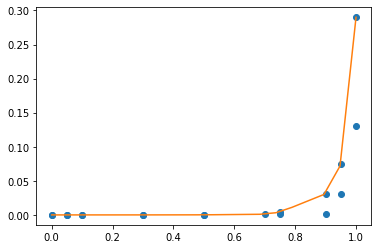

In [222]:
solubility_data = pd.read_excel(r"C:\Users\Edwin\Desktop\octadecene solubility.xlsx")
solubility_data.columns = solubility_data.loc[0]
solubility_data = solubility_data.drop(0)
etoh = solubility_data['Ethanol wt% ']/100
ode_30 = solubility_data['30 C ']/100
ode_10 = solubility_data['10 C ']/100
ode_60 = solubility_data['60 C']/100

ex = etoh[ode_60.notnull()]
oy = ode_60[ode_60.notnull()]
plt.scatter(ewtf, owtf)
plt.yscale('linear')
# ex = ewtf
# oy= owtf
f = interp1d(ex, oy, kind='linear')
ex_new = np.linspace(0, 1, num=20, endpoint=True)
plt.plot(ex, oy, 'o', ex_new, f(ex_new), '-')

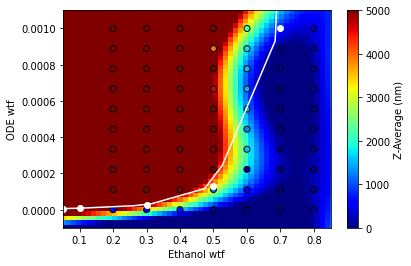

In [221]:
fig, ax = plt.subplots(1)
vmin = 0 # checking forl ower limit
vmax = 5000
norm =colors.Normalize(vmin=vmin,vmax=vmax) 

mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto',cmap='jet')
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel('Z-Average (nm)')
ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k',cmap='jet')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('ODE wtf')
ax.set_xlim(0.05,0.85)
ax.set_ylim(-0.0001,0.0011)
# plt.plot([0,1],[,0.05], c='r')
# ax.plot([0,1],[0,0.05], c='r')
# ax.set_title('SDS '+str(SDS) + ' wtf')
# x1a, x2a, y2a = gpm.xyz_in_between_z(vmin+vmax/2,vmax, x1_mesh_prep,x2_mesh_prep,y_mesh_prep)
# gpm.create_hull(x1a, x2a, graph=True)
plt.plot(ex, oy, 'o', ex_new, f(ex_new), '-', c = 'w')

QhullError: QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1818281049  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0


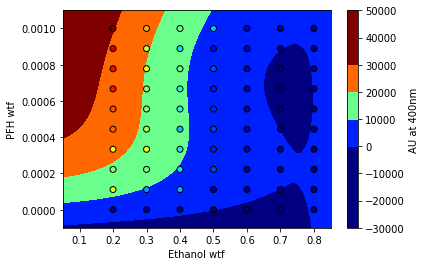

In [79]:

# Scatter plots for contour plot
fig, ax = plt.subplots(1)

vmin = min(y) 
vmax = max(y)

norm =colors.Normalize(vmin=vmin,vmax=vmax) 
cs = ax.contourf(X1,X2,Y, cmap='jet', norm=norm)
cbar = fig.colorbar(cs)

cbar.ax.set_ylabel('AU at 400nm')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')

ax.set_xlim(0.4,1)
ax.set_ylim(0, 0.0025)
ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k',cmap='jet')

ax.set_xlim(0.05,0.85)
ax.set_ylim(-0.0001,0.0011)

x1a, x2a, y2a = gpm.xyz_in_between_z(0.8,2, x1_mesh_prep,x2_mesh_prep,y_mesh_prep)
gpm.create_hull(x1a, x2a, graph=True)

# x1b, x2b, y2b = gpm.xyz_in_between_z(0.03,0.050, x1_mesh_prep,x2_mesh_prep,y_mesh_prep)
# gpm.create_hull(x1b, x2b, graph=True)

In [ ]:
# BROKEN BELOW

In [ ]:
dppc_conc = comp1[0]
dspepef_conc = comp2[0]
# Scatter plots for contour plot
fig, ax = plt.subplots(1)

vmin = min(y) 
vmax = max(y)

norm =colors.Normalize(vmin=vmin,vmax=vmax) 
# cs = ax.contourf(X1,X2,Y, cmap='jet', norm=norm)
# cbar = fig.colorbar(cs)

# cbar.ax.set_ylabel('AU at 400nm')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')
ax.set_title(str(percent_random)+' Percent of Original Samples')
# ax.text(0.4,0.0025, 'HII)
ax.set_xlim(0.6,0.8)
ax.set_ylim(0, 0.0015)
total = ax.scatter(x1,x2,c='blue', norm=norm, edgecolors='k',cmap='jet')
x1a, x2a, y2a = xyz_in_between_z(0.065,0.11, x1_mesh_prep,x2_mesh_prep,y_mesh_prep)
x1b, x2b, y2b = xyz_in_between_z(0.03,0.050, x1_mesh_prep,x2_mesh_prep,y_mesh_prep)

hulla = create_hull(x1a, x2a, graph=True)
hull_2d_pointsa = np.asarray([x1a, x2a]).T[0]
hullb = create_hull(x1b, x2b, graph=True)
hull_2d_pointsb = np.asarray([x1b, x2b]).T[0]

hull_1scatter =[]
for x1i,x2i in zip(x1,x2):
    if point_in_hull(hulla,hull_2d_pointsa,x1i,x2i) == True:
        hull_1scatter.append([x1i,x2i])
hull_1scatter = np.asarray(hull_1scatter)        
plt.fill(hull_2d_pointsa[hulla.vertices,0], hull_2d_pointsa[hulla.vertices,1], 'aqua', alpha=0.3)
a = plt.scatter(hull_1scatter[:,0],hull_1scatter[:,1] , c='red',edgecolors='k')

hull_2scatter =[]
for x1i,x2i in zip(x1,x2):
    if point_in_hull(hullb,hull_2d_pointsb,x1i,x2i) == True:
        hull_2scatter.append([x1i,x2i])
hull_2scatter = np.asarray(hull_2scatter)        
b = plt.scatter(hull_2scatter[:,0],hull_2scatter[:,1],c='grey', linewidth=0)


plt.legend((total, a, b),
           ('Classification A', 'Classification B', 'Classification C'),
           scatterpoints=1,
           loc='upper left',
           ncol=1,
           fontsize=8)

# classify select if greater than x value, then draw convex hull

In [ ]:
# Scatter plots for contour plot
fig, ax = plt.subplots(1)



vmin = min(y) 
vmax = max(y)
norm =colors.Normalize(vmin=vmin,vmax=vmax) 
# mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto',cmap='jet')
cs = ax.contourf(X1,X2,Y, cmap='jet', norm=norm)
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel('AU at 400nm')

ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')
# ax.set_xlim([0.5,1])
# ax.set_ylim(0, 0.0025)
for coll in cs.collections:
    coll.set_clip_path(p)
    
    
# ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k',cmap='jet')

In [ ]:
fig, ax = plt.subplots(1)
ax.tricontour(x1, x2, levels=14, linewidths=0.5, colors='k')

In [ ]:
# Scatter plots for contour plot
fig, ax = plt.subplots(1)

vmin = min(y) 
vmax = max(y)
norm =colors.Normalize(vmin=vmin,vmax=vmax) 
cs = ax.contourf(X1,X2,Y, cmap='jet', norm=norm)
cbar = fig.colorbar(cs)
# mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto',cmap='jet')
cbar.ax.set_ylabel('AU at 400nm')
ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k',cmap='jet')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')
ax.set_xlim(0.4, 1)
ax.set_ylim(0, 0.0025)
ax.scatter(x1,x2,c=y, norm=norm,cmap='jet')

In [ ]:
%matplotlib qt
# populate outline with expl. of what you are doing here: What is robust scalar, fundamentals of model and limitations. 
# Contour plot, with convex hull

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,x2,y, c=y, norm=norm, cmap='jet')
ax.plot_surface(X=X1, Y=X2, Z=Y, norm=norm, rstride=1, alpha =0.1, cstride=1, cmap='jet', linewidth=0, antialiased=False)

cbaxes = fig.add_axes([0.7, 0.85, 0.2, 0.03]) 
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap='jet'), shrink=0.3, aspect=5, cax = cbaxes, orientation='horizontal')
cb.ax.set_title('AU at 400nm', rotation=0)

ax.set_xlabel('Ethanol (wtf)')
ax.set_ylabel('Perfluorocarbon (wtf)')
ax.set_zlabel('AU at 400nm')
# ax.set_zlim(0.0,0.1)

# ax.contourf(X1,X2,Y, zdir='z',offset=0.04, cmap='jet', norm=norm)
# for coll in cs.collections:
#     coll.set_clip_path(p)

In [ ]:
xI = x1_mesh_prep[:,0].tolist()
yI = x2_mesh_prep[:,0].tolist()
zI = y_mesh_prep[:,0].tolist()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(xI,yI,zI)
ax.scatter(x1,x2,y, c=y, norm=norm, cmap='jet')


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


n_radii = 8
n_angles = 36

# Make radii and angles spaces (radius r=0 omitted to eliminate duplication).
radii = np.linspace(0.125, 1.0, n_radii)
angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)

# Repeat all angles for each radius.
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)

# Convert polar (radii, angles) coords to cartesian (x, y) coords.
# (0, 0) is manually added at this stage,  so there will be no duplicate
# points in the (x, y) plane.
x = np.append(0, (radii*np.cos(angles)).flatten())
y = np.append(0, (radii*np.sin(angles)).flatten())

# Compute z to make the pringle surface.
z = np.sin(-x*y)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)

plt.show()
x.shape

In [ ]:
y_mesh_prep.shape

In [ ]:
# plot with MSE
# populate outline with expl. of what you are doing here: What is robust scalar, fundamentals of model and limitations. 
# Contour plot, with convex hull

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,x2,y, c=y, norm=norm, cmap='jet')
surf = ax.plot_surface(X=X1, Y=X2, Z=Y, norm=norm, rstride=1, alpha =0.1, cstride=1, cmap='jet', linewidth=0, antialiased=False)

cbaxes = fig.add_axes([0.7, 0.85, 0.2, 0.03]) 
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap='jet'), shrink=0.3, aspect=5, cax = cbaxes, orientation='horizontal')
cb.ax.set_title('AU at 400nm', rotation=0)

ax.set_xlabel('Ethanol (wtf)')
ax.set_ylabel('Perfluorocarbon (wtf)')
ax.set_zlabel('AU at 400nm')
# ax.set_zlim(0.0,0.1)


for coll in surf.collections:
    coll.set_clip_path(p)

In [ ]:
hull = create_hull(x1_training[:, np.newaxis],x2_training[:, np.newaxis], graph=True)    

hull_indices = hull.vertices
hull_pts = pts[hull_indices, :]


y = hull_pts

p = Polygon(y, facecolor = 'k')

fig,ax = plt.subplots()

ax.add_patch(p)
ax.set_xlim(0.4, 1)
ax.set_ylim(0, 0.0025)
plt.show()

# Scatter plots for contour plot
fig, ax = plt.subplots(1)

cs = ax.contourf(X1,X2,Y)
ax.scatter(x1_training,x2_training)
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')

ax.set_xlim(0.4, 1)
ax.set_ylim(0, 0.0025)
for coll in cs.collections:
    coll.set_clip_path(p)

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.mlab import griddata
import numpy as np
import pandas as pd

df = pd.DataFrame({'x':[0, 0, 1, 1, 3, 3, 3, 4, 4, 4], 
                   'y':[0, 1, 0, 1, 0.2, 0.7, 1.4, 0.2, 1.4, 2], 
                   'z':[50, 40, 40, 30, 30, 30, 20, 20, 20, 10]})

x = df['x']
y = df['y']
z = df['z']

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
z_grid = griddata(x, y, z, xi, yi, interp='linear')

clipindex = [ [0,2,4,7,8,9,6,3,1,0],
              [0,2,4,7,5,8,9,6,3,1,0],
              [0,2,4,7,8,9,6,5,3,1,0]]

fig, axes = plt.subplots(ncols=3, sharey=True)
for i, ax in enumerate(axes):
    cont = ax.contourf(xi, yi, z_grid, 15)
    ax.scatter(x, y, color='k') # The original data points
    ax.plot(x[clipindex[i]], y[clipindex[i]], color="crimson")

    clippath = Path(np.c_[x[clipindex[i]], y[clipindex[i]]])
    patch = PathPatch(clippath, facecolor='none')
    ax.add_patch(patch)
    for c in cont.collections:
        c.set_clip_path(patch)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.patches as patches

def func(x, y):
  return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

fig, ax = plt.subplots()
cs = ax.contourf(grid_x,grid_y,grid_z0)

circ = patches.Circle((0.6, 0.4), 0.3, transform=ax.transData)

for coll in cs.collections:
    coll.set_clip_path(p)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


Z = np.array([
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    [ 1, 1, 1, 1, 1, ],
    ])

x, y = Z.shape

xs = np.arange(x)
ys = np.arange(y)
X, Y = np.meshgrid(xs, ys)


R = np.where(X>=Y, Z, np.nan)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, linewidth=0)

fig.show()
R

In [ ]:
hull = create_hull(x1_training_scaled,x2_training_scaled, graph=True)    

# x1_hull = []
# x2_hull = []
# for x1,x2 in zip(x1_test_ex, x2_test_ex):
#     if point_in_hull(hull, x1,x2) == True:
#         x1_hull.append(x1)
#         x2_hull.append(x2)
#         plt.plot(x1,x2,'o',c='r')
        
# x1_hull = np.asarray(x1_hull)
# x2_hull = np.asarray(x2_hull)

In [ ]:
x1 = x1_training[:, np.newaxis]
x2 = x2_training[:, np.newaxis]

pts = np.asarray([x1,x2]).T[0]
ch = ConvexHull(pts)
hull_indices = ch.vertices
hull_pts = pts[hull_indices, :]

plt.plot(pts[:, 0], pts[:, 1], 'ko', markersize=10)
plt.plot(hull_pts[:, 0], hull_pts[:, 1], 'ro', alpha=.25, markersize=20)

plt.show()

print(hull_pts[0:5])
print(ch.simplices)

In [ ]:
hull_pts

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

verts = hull_pts[0:8]

codes = [
    Path.MOVETO,
    Path.LINETO, # add more to more complex
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

path = Path(verts, codes)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
# ax.set_xlim(-2, 2)
ax.set_ylim(0, 0.003)
plt.show()
print(patch)

In [ ]:
verts = hull_pts[0:6]

codes = [
    Path.MOVETO,
    Path.CURVE3,
    Path.CURVE3,
    Path.CURVE3,
    Path.CURVE3,
    Path.CLOSEPOLY
]

path = Path(verts, codes)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)

xs, ys = zip(*verts)
# ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)
ax.set_ylim(0,0.0025)
ax.set_xlim(0.4,1)
plt.scatter(x1_training, x2_training)
plt.show()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import os
import subprocess

In [ ]:
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Create a figure and a 3D Axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def init():
    # Plot the surface.
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    return fig,

def animate(i):
    # azimuth angle : 0 deg to 360 deg
    ax.view_init(elev=10, azim=i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=90, interval=50, blit=True)

In [ ]:
os.getcwd()
fn = 'rotate_azimuth_angle_3d_surf_slow'
ani.save(fn+'.gif',writer='imagemagick',fps=1000/50)

In [ ]:
cmd = 'magick convert %s.gif -fuzz 5%% -layers Optimize %s_r.gif'%(fn,fn)# #this saves it/stitches it together
# plt.rcParams['animation.html'] = 'html5'
# ani